# Validate ARM

In [1]:
import os
from pathlib import Path
SCRIPT_DIR = os.path.dirname(os.path.abspath("__init__.py"))
SRC_DIR = Path(SCRIPT_DIR).parent.absolute()
print(SRC_DIR)

/Users/yannis/PycharmProjects/WeRec3D/src


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

from plotting import display_predictions

In [4]:
FULL_PRED_FILE = "predictions/full_pred_arm.npy"

In [5]:
DATES = pd.date_range('1807-01-01', freq='D', periods=365).values
DATES = list(map(lambda d: str(d).split('T')[0], DATES))
def date_to_id(date):
    return DATES.index(date)

## Full

In [6]:
pred = np.load(FULL_PRED_FILE)
pred.shape

(365, 32, 64, 2)

In [7]:
# Convert to hecto pascal
pred[...,1] = pred[...,1] /100

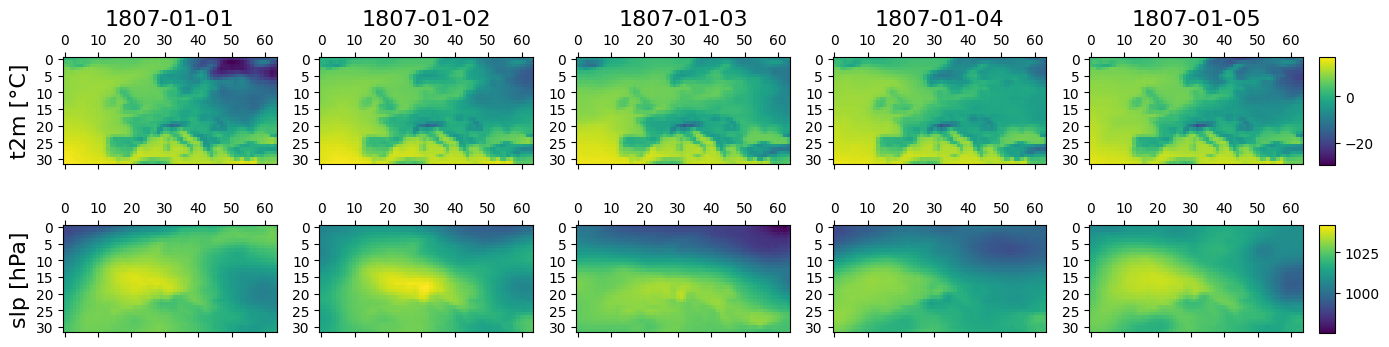

In [8]:
date = "1807-01-01"
day_id = date_to_id(date)
fig = display_predictions(pred, day_id, date)

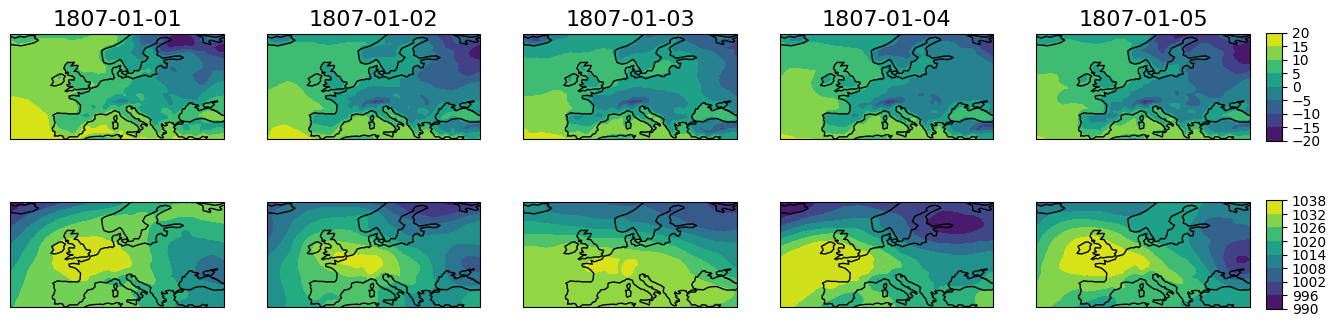

In [9]:
fig = display_predictions(pred, day_id,date, show_contours=True)

## LOO

In [10]:
import xarray as xr

from data_transformer import extract_stations_from_nc
from data_provider import get_station_indices_map

from taylor_helpers import get_nan_ids, extract_anomalies, get_loo_taylor_metrics
from plotting import create_normed_taylor_diagram

In [11]:
GROUND_TRUTH = "data_sets/ground_truth.nc"
LOO_PRED_FILE = "predictions/loo_pred_arm.nc"

In [12]:
station_indx_map = get_station_indices_map()
ground_truth = xr.load_dataset(GROUND_TRUTH)
gt_stations = extract_stations_from_nc(ground_truth, station_indx_map)  # Is scaled.

pred = xr.load_dataset(LOO_PRED_FILE)
pred_stations = extract_stations_from_nc(pred, station_indx_map)

In [13]:
missing_indicies = get_nan_ids(gt_stations)
anomaly_pred_stations = extract_anomalies(pred_stations, station_indx_map)                  # Pred has no NaNs
anomaly_gt_stations = extract_anomalies(gt_stations, station_indx_map, missing_indicies)    # GT has NaNs
taylor_metrics = get_loo_taylor_metrics(anomaly_gt_stations, anomaly_pred_stations, missing_indicies)

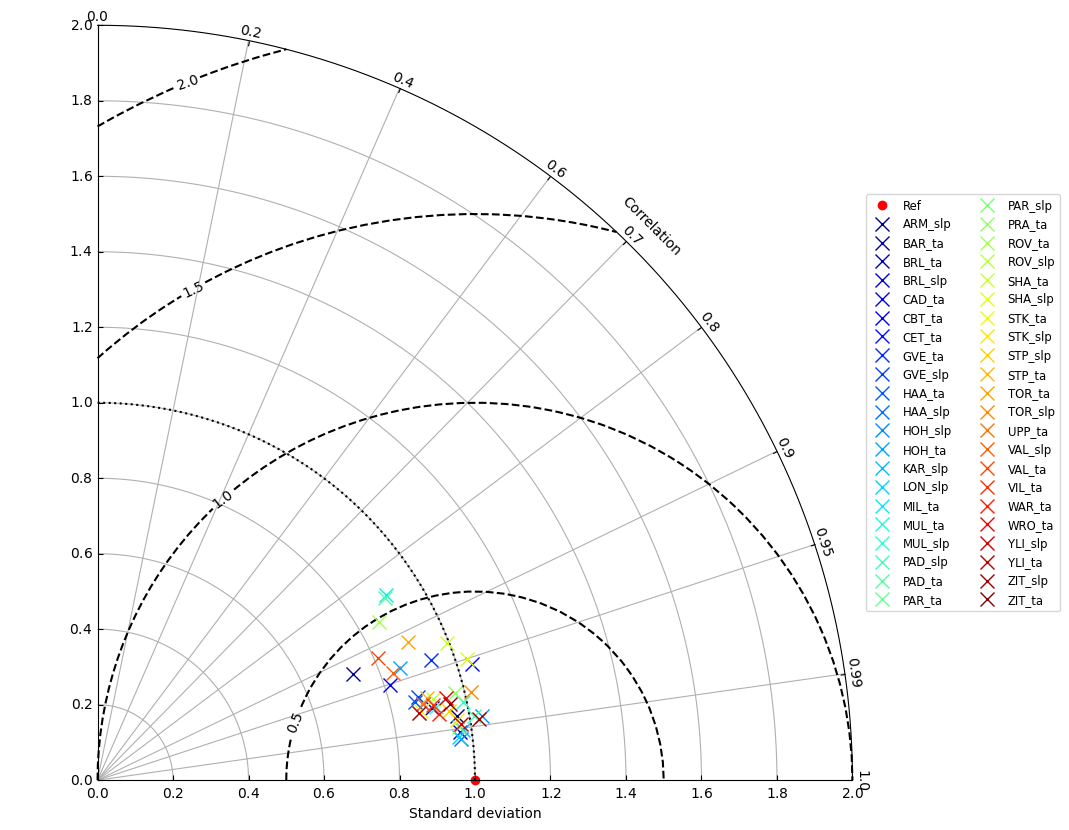

In [14]:
fig = create_normed_taylor_diagram(ref_std=1,
                                   test_std_devs=[m['norm_std'] for m in taylor_metrics.values()],
                                   test_corrs=[m['corr'] for m in taylor_metrics.values()],
                                   labels=list(taylor_metrics.keys()),
                                   )

fig.savefig(f"figures/taylor_loo_arm.png", bbox_inches='tight', pad_inches=0.1)

### RMSE on LOO (non normalized)

In [15]:
rmse_stations_ta = []
rmse_stations_slp = []

for station_id in gt_stations.keys():
    pred = pred_stations[station_id]
    gt = gt_stations[station_id]
    if missing_indicies[station_id]:
        pred = np.delete(pred, missing_indicies[station_id])
        gt = np.delete(gt, missing_indicies[station_id])
    
    rmse_station = np.sqrt(np.mean(np.square(gt - pred)))
    if "_ta" in station_id:
        rmse_stations_ta.append(rmse_station)
    else:
        rmse_stations_slp.append(rmse_station)

print(np.mean(rmse_stations_ta))
print(np.mean(rmse_stations_slp))
    

1.1635582502487236
178.58403508812899
